In [1]:
!pip install yfinance
!pip install ta
!pip install --upgrade pandas-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.4 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for ta: filename=ta-0.10.2-py3-none-any.whl size=29104 sha256=799886f96909212ccc9cfa8c911a37351deae68806f677fd824be18ed82c0d2b
  Stored in directory: /root/.cache/pip/wheels/31/31/f1/f2ff471bbc5b84a4b973698ceecdd453ae043971791adc3431
Successfully built ta
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109 kB 4.4 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successf

In [2]:
import numpy as np
import pandas as pd
import math
from datetime import date, timedelta


import pandas_datareader as pdr

import yfinance as yf
import matplotlib.pyplot as plt

import statsmodels
from statsmodels.tsa.stattools import coint

import seaborn as sb

from ta.trend import SMAIndicator

# Trade Class

Trade class encapsulate the logic of handling a single trade in our backtester.
For every Buy - Sell it will be counted as 1 trade. 

A Backtester will have many trades.


In [3]:
class Trade() :
    
    #average open price is the price per stock inlcuding transaction fees
    def __init__(self, symbol, date, open_price, position, quantity, transaction_cost) :
        
        self.symbol = symbol
        self.date = date
        self.open_price = open_price
        self.position = position
        self.quantity = quantity
        self.transaction_cost = transaction_cost
        
        self.close_price = None
        self.close_date = None
        self.returns = None
        self.raw_profits = None
        
        self.print_start_trade()
        
    def print_start_trade(self) :
        action = "Buy" if self.position == 1 else "Sell"
        print(f"Open Trade {self.symbol} | {self.date[:10]} | {action}")
        print("===============")
        print(f"Open Price: ${self.open_price}")
        print(f"Quantity: {self.quantity}")
        print(f"Transaction Cost: ${round(self.transaction_cost * self.open_price * self.quantity)}")
        print(f"Total Price: ${round(self.open_price * self.quantity* (1 + self.transaction_cost), 2)}")
        print()

        
    def close_trade(self, close_date, close_price) :
        
        self.close_price = close_price
        self.close_date = close_date
        
        if self.position == 1 :
            close_quantity = -self.quantity
            self.returns = np.log(self.close_price/ self.open_price)
            self.raw_profits = (self.close_price - self.open_price) * self.quantity
            print(f"Closing Trade {self.symbol} | {close_date[:10]} | Sell")
            
        elif self.position == -1 :
            close_quantity = self.quantity
            self.returns = np.log(self.open_price/ self.close_price)
            self.raw_profits = (self.open_price - self.close_price) * self.quantity
            print(f"Closing Trade {self.symbol} | {self.close_date[:10]} | Buy")
            
        
        print("===============")
        print(f"Close Price: ${round(close_price, 2)}" )
        print(f"Quantity: {self.quantity} ")
        print(f"Total Price: ${round(close_price * self.quantity, 2)}")
        print(f"Log Returns: {self.returns}")
        print(f"Raw Profits: ${self.raw_profits}")
        print("======================================")
        print()
        
        self.position = 0
        
    def get_unrealised_profits(self, current_price) :
        return (current_price - self.open_price) * self.quantity * self.position



# BackTester

Since we will be handling multiple stocks, trade logic will be encapsulate in the Trade Class and Backtester class will be mainly handling the logic of Buying and Selling.

We will also need to store the different trades in a dictionary to keep track of all the different stocks. 

# Assumptions Made
1. At a single instance, each individual stock can only have one open trade.

2. Opening and Closing a Trade is counted as 1 Trade together

3. Capital Allocation to each stock is *Total Capital / n stocks* hence all stocks will have equal weights in the strategy.

4. Quantity is calculated base on the price and the transaction cost. <br>
For example, Capital of \$1000 could buy 9 x \$10 worth of stocks as the transaction cost is *tc x 9 x 10*. <br>
Hence the price needed is (9 x $10) + (tx x 9 x 10)

5. The formula used to derive the maximum quantity is : *Capital / (price + (price * TC))*

In [4]:
class BackTester():  

    def __init__(self, symbols, start, end, interval, capital, transcation_cost, market_benchmark, verbose = True):

        self.symbols = symbols
        self.start = start
        self.end = end
        self.interval = interval
        self.initial_capital = capital # this is the initial capital you want to trade with
        self.capital = capital # this capital will change depending on trades
        self.stocks_capital = {} ## fix allocation of cash for weach symbol
        self.transaction_cost = transcation_cost # the transaction cost for trading
        self.history_trades = {} #upon closing a trade, the trade will be added here
        self.open_trades = {} # each stock will only have 1 trade open at a time 
        self.verbose = verbose # if you want to see detailed output (logs) 
        self.rolling_capital = pd.DataFrame() # captial daily status
        
        self.market_benchmark = market_benchmark
        
        self.prepare_cash_allocation()
        self.prepare_data() # prepares the data

    def prepare_data(self):
        # since we are building a common class for all types of strategy, we will not calcualte the moving averages now.
        # we will calculate the returns though.
        # Since most strategies utilise close prices we are only factoring close price. However, you can alter acoordingly.
        bt_data = pd.DataFrame()
        for symbol in self.symbols : 
            stock_data = yf.Ticker(symbol)
            hist_stock = stock_data.history(start = self.start, end = self.end, interval = self.interval)
            bt_data[f"Close_Price_{symbol}"] = hist_stock["Close"]
            bt_data[f"Return_{symbol}"] = np.log(bt_data[f"Close_Price_{symbol}"] / bt_data[f"Close_Price_{symbol}"].shift(1))

        benchmark_stock = yf.Ticker(self.market_benchmark)
        benchmark_hist = benchmark_stock.history(start = self.start, end = self.end, interval = self.interval)
        bt_data[f"Close_Price_{self.market_benchmark}"] = hist_stock["Close"]
        bt_data[f"Return_{self.market_benchmark}"] = np.log(bt_data[f"Close_Price_{self.market_benchmark}"] / bt_data[f"Close_Price_{self.market_benchmark}"].shift(1))
            
        bt_data = bt_data.dropna()
        self.data = bt_data
        self.rolling_capital["Date"] = self.data.index
        self.rolling_capital["Capital"] = self.capital

        print(self.data)

        
    def prepare_cash_allocation(self) :
        num_stocks = len(self.symbols)
        for symbol in self.symbols :
            self.stocks_capital[symbol] = self.initial_capital / num_stocks

    def close_graph(self):
        for symbol in self.symbols : 
            plt.figure(figsize=(15, 5))
            plt.plot(self.data[f"Close_Price_{symbol}"] ,color='black', label='Price', linestyle='dashed')
            plt.xlabel("Days")
            plt.ylabel("Price")
            plt.title("Close Prices of {}".format(symbol))
            plt.legend()
            plt.grid()
            plt.show()     

    def return_date_price(self, bar, symbol=None):
        # A bar is a unit of data at a given time, depends on the interval you choose, it provides you OHLCV and time info
        # Since we have modeled close prices, we will get the price and date
        date = str(self.data.index[bar])
        price = None
        if symbol :
            price = self.data[f"Close_Price_{symbol}"].iloc[bar]
        return date, price

    def realised_balance(self, bar):
        #Returns you the realised capital in your account at a given time period / bar
        date, price = self.return_date_price(bar)
        
        return self.capital

    def unrealised_balance(self, bar):
        #Returns you the unrealised capital (trades in progress) in your account at a given time period / bar
        ub = 0
        for symbol, trade in self.open_trades.items() :
            date, price = self.return_date_price(bar, symbol)
            ub += trade.quantity * price
        return ub
            

    def total_balance(self, bar):
        #Unrealised plus realised
        ub = 0
        for symbol, trade in self.open_trades.items() :
            date, price = self.return_date_price(bar, symbol)
            ub += trade.quantity * price

        tb = ub + self.capital
        
        return tb

    def get_returns(self) :
      return (self.capital - self.initial_capital) /self.initial_capital * 100
        

    def buy_order(self, bar, symbol, quantity=None, dollar=None,):
        date, price = self.return_date_price(bar, symbol)
        quant = 0
        
        # if symbol is in open trades, there is a open short position
        if symbol in self.open_trades :
            current_trade = self.open_trades[symbol]
            current_trade.close_trade(close_date=date, close_price=price)
            if symbol in self.history_trades : 
                self.history_trades[symbol].append(current_trade)
            else : 
                self.history_trades[symbol] = [current_trade]
            
            quant = current_trade.quantity
            price_delta = current_trade.open_price - price
            
            difference = price_delta * quant 
            
            open_sum = current_trade.open_price * current_trade.quantity
            
            self.capital = self.capital - (quant * price)*(self.transaction_cost) + open_sum + difference
            self.stocks_capital[symbol] = open_sum + difference - (quant * price)*(self.transaction_cost)
            
            del self.open_trades[symbol]
        else :
            if quantity == None:
                quant = math.floor(self.stocks_capital[symbol] / (price + (self.transaction_cost * price)))
                
            new_trade = Trade(symbol=symbol, date=date, open_price=price, position=1, quantity=quant, transaction_cost=self.transaction_cost)
            self.open_trades[symbol] = new_trade 
            
            self.capital = self.capital - ((quant * price)*(1 + self.transaction_cost)) # capital will be lost in buying
            self.stocks_capital[symbol] = self.stocks_capital[symbol] - (quant * price)*(1 + self.transaction_cost)
           
        if self.verbose:
            print(f"Realised Balance ${round(self.realised_balance(bar), 2)}")
            print(f"Unrealised Balance ${round(self.unrealised_balance(bar), 2)}")
            print(f"Total Balance ${round(self.total_balance(bar), 2)}")
            print()
            
            
    def sell_order(self, bar, symbol, quantity=None, dollar=None):
        date, price = self.return_date_price(bar, symbol)
        quant = 0
        
        # if symbol is in open trades, there is a open long position
        if symbol in self.open_trades :
            current_trade = self.open_trades[symbol]
            current_trade.close_trade(close_date=date, close_price=price)
            if symbol in self.history_trades : 
                self.history_trades[symbol].append(current_trade)
            else : 
                self.history_trades[symbol] = [current_trade]
            
            quant = current_trade.quantity
            self.capital = self.capital + ((quant * price)*(1 - self.transaction_cost)) # capital will be added after selling
            self.stocks_capital[symbol] = (quant * price)*(1 - self.transaction_cost)
            
            del self.open_trades[symbol]
            
        else :
            if quantity == None:
                quant = math.floor(self.stocks_capital[symbol] / (price + (self.transaction_cost * price)))
            new_trade = Trade(symbol=symbol, date=date, open_price=price, position=-1, quantity=quant, transaction_cost=self.transaction_cost)
            self.open_trades[symbol] = new_trade
            
            self.capital = self.capital - ((quant * price)*(1 + self.transaction_cost))
            self.stocks_capital[symbol] = self.stocks_capital[symbol]- (quant * price)*(1 + self.transaction_cost)
            if self.verbose:
                print(f"Realised Balance ${round(self.realised_balance(bar), 2)}")
                print(f"Unrealised Balance ${round(self.unrealised_balance(bar), 2)}")
                print(f"Total Balance ${round(self.total_balance(bar), 2)}")
                print()

    # Close any open position at the end of the backtesting
    def last_trade(self, bar):
        for symbol, trade in  self.open_trades.items() : 
            
            date, price = self.return_date_price(bar, symbol)
            
            trade.close_trade(close_date=date, close_price=price)
            
            self.capital = self.capital + (trade.quantity * price)* (1-self.transaction_cost)
            
            if self.verbose:
                print("Closed open trades for {} shares of {} at {:0.1f} per share worth {:0.1f} $"\
                    .format(trade.quantity ,symbol, price, trade.quantity * price))
                self.total_balance(bar)    

        returns = self.get_returns()
        print("The total capital at end of strategy: {:0.1f}".format(self.capital))
        print( "The strategy returns on investment are {:0.1f} %".format(returns))
        print( "Total trades by strategy are {:0.1f}".format(self.calcuate_total_trades()))

        
    def calcuate_total_trades(self) :
        total_trades = 0
        for symbol, trades in self.history_trades.items() :
            total_trades += len(trades)

        return total_trades

    def generate_individual_stocks_drawdown(self) :
        for symbol in self.symbols :
          self.data[f"Gross_Cum_Returns_{symbol}"] = self.data[f"Strategy_Returns_{symbol}"].cumsum().apply(np.exp)
          self.data[f"Cum_Max_{symbol}"] = self.data[f"Gross_Cum_Returns_{symbol}"].cummax()

          self.data[[f"Gross_Cum_Returns_{symbol}", f"Cum_Max_{symbol}"]].dropna().plot(figsize =(15,6), title=f"{symbol} DrawDown")

    def performance(self) :
      self.rolling_capital["Capital_After_Resettlement"] = self.rolling_capital["Capital"].shift(-1)

      self.rolling_capital['Capital_Regular_Returns'] = (self.rolling_capital['Capital_After_Resettlement']/self.rolling_capital['Capital'] - 1)
      self.rolling_capital['Capital_Log_Returns'] = np.log(self.rolling_capital['Capital_After_Resettlement'] / self.rolling_capital['Capital'])
      self.rolling_capital['Capital_Returns_Log_Cum_Sum'] = self.rolling_capital['Capital_Log_Returns'].cumsum()

      self.rolling_capital['Cum_Max'] = self.rolling_capital['Capital_Returns_Log_Cum_Sum'].cummax()
      self.rolling_capital['Drawdown'] = self.rolling_capital['Capital_Returns_Log_Cum_Sum']

      self.rolling_capital[["Drawdown", f"Cum_Max"]].dropna().plot(figsize =(15,6), title=f"Capital DrawDown")

    def calmar_ratio(self) :
      max_drawdown = max(self.rolling_capital['Cum_Max'] - self.rolling_capital['Drawdown'])
      return self.get_returns()/(max_drawdown*100)

    def sortino_ratio(self) :
      negative_returns_df = self.rolling_capital[self.rolling_capital["Capital_Log_Returns"] < 0]
      negative_returns = negative_returns_df["Capital_Log_Returns"]

      negative_regular_returns = np.exp(negative_returns) - 1

      annual_negative_sd = negative_regular_returns.std() * (252 ** 0.5)

      sortino = (self.get_returns() / 100) / annual_negative_sd

      return sortino

    def information_ratio(self) :   

      temp_data = self.rolling_capital.copy()
      temp_data.set_index('Date', inplace=True)

      temp_data["Market_Returns"] = self.data[f"Return_{self.market_benchmark}"]

      temp_data["Strategy_Benchmark"] = temp_data["Capital_Log_Returns"] - temp_data["Market_Returns"]

      average_of_difference = temp_data["Strategy_Benchmark"].mean()

      std_dev_of_difference = temp_data["Strategy_Benchmark"].std()

      IR_daily = average_of_difference / std_dev_of_difference

      IR_annual = IR_daily * (252 ** 0.5)

      return IR_annual

    def treynor_ratio(self) :
      temp_data = self.rolling_capital.copy()

      temp_data.set_index('Date', inplace=True)
      temp_data["Market_Returns"] = self.data[f"Return_{self.market_benchmark}"]
      
      cov_matrix = temp_data[["Capital_Log_Returns", "Market_Returns"]].cov()

      beta = cov_matrix.iat[0,1] / cov_matrix.iat[1,1]
      
      return (self.get_returns() / 100) / beta

    def get_extended_metrics(self) :
        print(f"Calmar Ratio: {self.calmar_ratio()}")
        print(f"Sortino Ratio: {self.sortino_ratio()}")
        print(f"Annual Information Ratio: {self.information_ratio()}")
        print(f"Treynor Ratio: {self.treynor_ratio()}")
 

                           Close_Price_AAPL  Return_AAPL  Close_Price_META  \
Date                                                                         
2015-01-05 00:00:00-05:00         23.949760    -0.028576         77.190002   
2015-01-06 00:00:00-05:00         23.952015     0.000094         76.150002   
2015-01-07 00:00:00-05:00         24.287876     0.013925         76.150002   
2015-01-08 00:00:00-05:00         25.221067     0.037702         78.180000   
2015-01-09 00:00:00-05:00         25.248117     0.001072         77.739998   
...                                     ...          ...               ...   
2022-06-24 00:00:00-04:00        141.463501     0.024222        170.160004   
2022-06-27 00:00:00-04:00        141.463501     0.000000        169.490005   
2022-06-28 00:00:00-04:00        137.249359    -0.030242        160.679993   
2022-06-29 00:00:00-04:00        139.036865     0.012940        163.940002   
2022-06-30 00:00:00-04:00        136.530350    -0.018192        

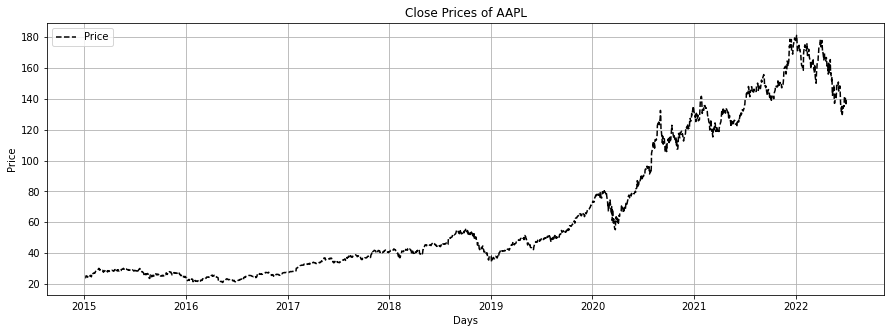

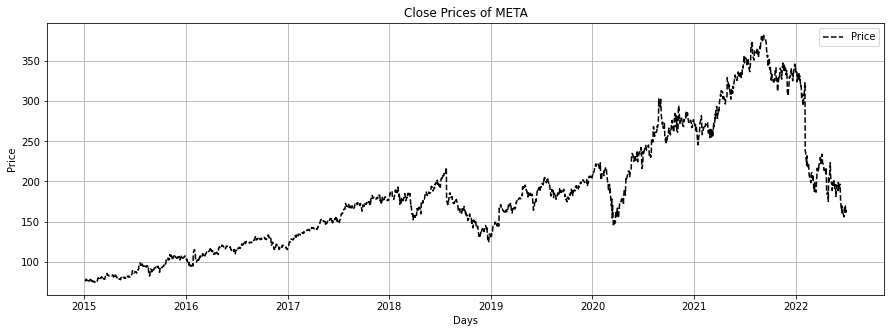

In [5]:
#check if common class runs fine
A = BackTester(["AAPL", "META"], "2015-01-01", "2022-07-01","1d", 10000, 0.0, "^GSPC", False)
A.close_graph()

In [6]:
class MA_Strategy(BackTester):
  
    def go_long(self, bar, symbol, quantity = None, dollar = None):
        if symbol in self.open_trades:
            self.buy_order(bar, symbol)
            
        elif quantity :
            self.buy_order(bar, symbol, quantity=quantity)
        elif dollar :
            if dollar == "all":
                dollar = self.stocks_capital[symbol] # capital is limited to the size of stock per trade
            self.buy_order(bar, symbol, dollar=dollar)

    def go_short(self, bar, symbol, quantity = None, dollar = None):
        if symbol in self.open_trades:
            self.sell_order(bar, symbol)
        if quantity :
            self.sell_order(bar, symbol, quantity = quantity)
        elif dollar :
            if dollar == "all" :
                dollar = self.stocks_capital[symbol] # capital is limited to the size of stock per trade
            self.sell_order(bar, symbol, dollar=dollar)
            
    def prepare_indicators(self, STMA_window, LTMA_window) :
        for symbol in self.symbols :
            indicator_1 = SMAIndicator(close=self.data[f"Close_Price_{symbol}"], window=STMA_window, fillna=False)
            STMA = indicator_1.sma_indicator()
            
            indicator_2 = SMAIndicator(close=self.data[f"Close_Price_{symbol}"], window=LTMA_window, fillna=False)
            LTMA= indicator_2.sma_indicator()
            
            self.data[f"STMA_{symbol}"] = STMA
            self.data[f"LTMA_{symbol}"] = LTMA

            self.data[f"Strategy_Returns_{symbol}"] = 0
        

    def run_strategy(self, STMA_window, LTMA_window):
        self.capital = self.initial_capital
        
        self.prepare_indicators(STMA_window, LTMA_window)
        
        for bar in range(LTMA_window, len(self.data)) :
            for symbol in self.symbols :
                if symbol not in self.open_trades or self.open_trades[symbol].position == -1: 
                    if self.data[f"STMA_{symbol}"].iloc[bar] > self.data[f"LTMA_{symbol}"].iloc[bar] :
                        self.go_long(bar, symbol, dollar="all")
                elif symbol in self.open_trades :
                    self.data[f"Strategy_Returns_{symbol}"].iloc[bar] = self.open_trades[symbol].position * self.data[f"Return_{symbol}"].iloc[bar]


                if symbol not in self.open_trades or self.open_trades[symbol].position == 1: 
                    if self.data[f"STMA_{symbol}"].iloc[bar] < self.data[f"LTMA_{symbol}"].iloc[bar]:
                        self.go_short(bar, symbol, dollar="all")

                self.rolling_capital["Capital"].iloc[bar] = self.total_balance(bar)
                
         
        print("-------------")
        self.last_trade(bar)


In [7]:
A = MA_Strategy(["BRITANNIA.NS"], "2010-06-01", "2021-06-01","1d", 10000, 0.01, "^GSPC" ,True)
A.run_strategy(50,200)

                           Close_Price_BRITANNIA.NS  Return_BRITANNIA.NS  \
Date                                                                       
2010-06-02 00:00:00+05:30                140.103973             0.005636   
2010-06-03 00:00:00+05:30                142.064148             0.013894   
2010-06-04 00:00:00+05:30                142.258911             0.001370   
2010-06-07 00:00:00+05:30                141.119324            -0.008043   
2010-06-08 00:00:00+05:30                140.485245            -0.004503   
...                                             ...                  ...   
2021-05-25 00:00:00+05:30               3329.019531             0.021423   
2021-05-26 00:00:00+05:30               3306.274414            -0.006856   
2021-05-27 00:00:00+05:30               3304.967773            -0.000395   
2021-05-28 00:00:00+05:30               3313.485107             0.002574   
2021-05-31 00:00:00+05:30               3337.101318             0.007102   

           

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Closing Trade BRITANNIA.NS | 2013-03-14 | Buy
Close Price: $232.58
Quantity: 32 
Total Price: $7442.54
Log Returns: -0.13430236337454377
Raw Profits: $-935.33642578125

Realised Balance $5745.05
Unrealised Balance $0
Total Balance $5745.05

Open Trade BRITANNIA.NS | 2013-03-15 | Buy
Open Price: $233.7044677734375
Quantity: 23
Transaction Cost: $54
Total Price: $5428.95

Realised Balance $316.1
Unrealised Balance $5375.2
Total Balance $5691.3

Closing Trade BRITANNIA.NS | 2016-02-11 | Sell
Close Price: $1173.3
Quantity: 23 
Total Price: $26986.01
Log Returns: 1.613522310682595
Raw Profits: $21610.807861328125

Open Trade BRITANNIA.NS | 2016-02-11 | Sell
Open Price: $1173.3048095703125
Quantity: 22
Transaction Cost: $258
Total Price: $26070.83

Realised Balance $961.41
Unrealised Balance $25812.71
Total Balance $26774.12

Closing Trade BRITANNIA.NS | 2016-08-17 | Buy
Close Price: $1496.77
Quantity: 22 
Total Price: $32928.89
Log Returns: -0.24348352588497238
Raw Profits: $-7116.18359375


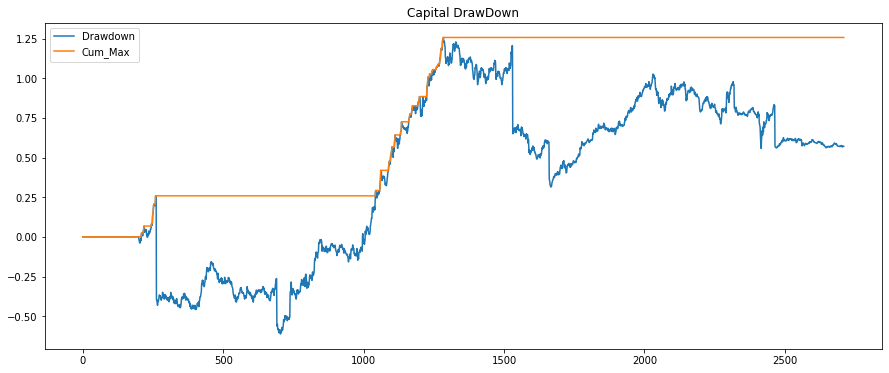

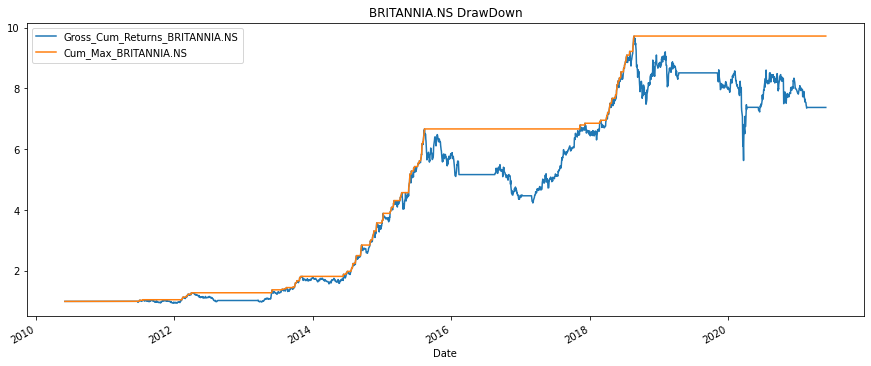

In [8]:
A.performance()
A.generate_individual_stocks_drawdown()

In [9]:
A.get_extended_metrics()

Calmar Ratio: 0.8138642475987652
Sortino Ratio: 2.121630529960258
Annual Information Ratio: -0.5294576155260328
Treynor Ratio: 112.73499553262675


In [10]:
A.rolling_capital

,Date,Capital,Capital_After_Resettlement,Capital_Regular_Returns,Capital_Log_Returns,Capital_Returns_Log_Cum_Sum,Cum_Max,Drawdown
0,2010-06-02 00:00:00+05:30,10000.000000,10000.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2010-06-03 00:00:00+05:30,10000.000000,10000.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2010-06-04 00:00:00+05:30,10000.000000,10000.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,2010-06-07 00:00:00+05:30,10000.000000,10000.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,2010-06-08 00:00:00+05:30,10000.000000,10000.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
2707,2021-05-25 00:00:00+05:30,17701.557917,17678.812800,-0.001285,-0.001286,0.569782,1.256704,0.569782
2708,2021-05-26 00:00:00+05:30,17678.812800,17677.506160,-0.000074,-0.000074,0.569708,1.256704,0.569708
2709,2021-05-27 00:00:00+05:30,17677.506160,17686.023494,0.000482,0.000482,0.570190,1.256704,0.570190
2710,2021-05-28 00:00:00+05:30,17686.023494,17709.639705,0.001335,0.001334,0.571524,1.256704,0.571524
